In [1]:
from floorplan import Box, Net, FloorPlan
#from floorplan_smt import Box, Net, FloorPlan

import cvxpy as cp
from cvxpy import Variable, Constant, Minimize, Problem
import placedb
import pylab
import math

import joblib

from sklearn.manifold import SpectralEmbedding

import scipy.io as io
import scipy.sparse.csgraph as csgraph

import jax
from jax import jit, vmap, random, grad
from jax.experimental import optimizers
from jax import numpy as jnp

from functools import partial
import itertools

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import datetime
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

/home/yuw/anaconda3/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Notes
- [Deprecated Warning] This code was developed using <0.2.22 Jaxlib version>
    - 07/20/2023: Updated to work on 0.3.33 Jaxlib version. Reference: https://discourse.pymc.io/t/pymc-4-0-0b6-module-jax-ops-has-no-attribute-index-update/9267/7
- Removed some of the unnecessary code regarding `placedb`


In [2]:
from ucsdpcb import PcbDB

trying to import ucsdpcb._PcbDB


In [3]:
numCores = joblib.cpu_count()

In [4]:
!ls PCBBenchmarks/

bm9  test  test.kicad_pcb


In [5]:
bm = 9
design = "bm{}".format(bm)
#pcb_path = "PCBBenchmarks/bm{}/bm{}.routed.kicad_pcb".format(bm,bm)
# pcb_path = "./BBBC.kicad_pcb".format(bm,bm)
pcb_path = "PCBBenchmarks/bm9/bm9.routed.kicad_pcb"
db = PcbDB.kicadPcbDataBase(pcb_path)

Build Kicad Pcb database...


(17.7934 10.847 2)


In [6]:
#pcb_path = "./output.bm12.routed.var.kicad_pcb"
#db = PcbDB.kicadPcbDataBase(pcb_path)

In [7]:
!ls PCBBenchmarks

bm9  test  test.kicad_pcb


In [8]:
name2idx = {}
compw = []
comph = []
compx = []
compy = []
movable = []
initrot = []
initm = []
mirror = []
netss = []
offsets = []
size = []

maxx = 0
maxy = 0
minx = 99999999
miny = 99999999

In [9]:
sumarea = 0

for i in range(db.getInstancesCount()):
    inst = db.getInstance(i)
    compid = inst.getComponentId()

    angle = int(inst.getAngle())
    if inst.isLocked():
        movable.append(False)
    else:
        movable.append(True)
    if (angle == 0):
        initrot.append(False)
        initm.append(False)
    elif (angle == 90):
        initrot.append(True)
        initm.append(False)
    elif (angle == 180):
        initrot.append(False)
        initm.append(True)
    elif (angle == 270):
        initrot.append(True)
        initm.append(True)
        
    compx.append(inst.getX() - 0.5 * ((1-int(initrot[-1]))*db.getCompBBoxW(compid) + 
                                      (int(initrot[-1]))*db.getCompBBoxH(compid)))
    compy.append(inst.getY() - 0.5 * ((1-int(initrot[-1]))*db.getCompBBoxH(compid) + 
                                      (int(initrot[-1]))*db.getCompBBoxW(compid)))
    compw.append(db.getCompBBoxW(compid))
    comph.append(db.getCompBBoxH(compid))
    
    if compx[-1] < minx:
        minx = compx[-1]
    if compy[-1] < miny:
        miny = compy[-1]
        
    if True:
        if compx[-1] + comph[-1] > maxx:
            maxx = compx[-1] + comph[-1]
        if compy[-1] + compw[-1] > maxy:
            maxy = compy[-1] + compw[-1]
    else:
        if compx[-1] + compw[-1] > maxx:
            maxx = compx[-1] + compw[-1]
        if compy[-1] + comph[-1] > maxy:
            maxy = compy[-1] + comph[-1]
    
    print(i,inst.getX(), inst.getY(), initrot[-1], db.getCompBBoxW(compid), db.getCompBBoxH(compid), 
          angle, not inst.isLocked())
    sumarea += db.getCompBBoxW(compid)* db.getCompBBoxH(compid)
print("util: {}".format(sumarea/((maxx-minx)*(maxy-miny))))
print('num nodes: {} ({} movable)'.format(len(compx), len([m for m in movable if m])))

0 149.606 100.8634 True 4.04 2.06 270 True
1 151.8666 100.8634 True 4.04 2.06 270 True
2 140.5636 105.2322 True 4.04 2.06 90 True
3 142.7988 100.6856 False 4.04 2.06 180 True
4 145.0594 105.2068 True 6.2 6.2 270 True
5 149.479 108.6104 True 4.2 2.2 270 True
6 151.7396 108.585 True 4.2 2.2 270 True
7 156.083 104.902 True 10.2 3.7 90 False
util: 0.5859955650013281
num nodes: 8 (7 movable)


In [10]:
for i in range(db.getNumNets()):
    net = db.getNet(i)
    pins = net.getPins()
    netss.append([])
    offsets.append([])
    for p in pins:
        instid = p.getInstId()
        netss[-1].append(instid)
        px = db.getPinPositionX(p)
        py = db.getPinPositionY(p)
        inst = db.getInstance(instid)
        ix = inst.getX() 
        iy = inst.getY()
        w = comph[instid]
        h = compw[instid]
        #ix = compx[instid]
        #iy = compy[instid]
        #xoff = ((1-int(initrot[instid]))*compw[instid] + 
        #                              (int(initrot[instid]))*comph[instid])
        #yoff = ((1-int(initrot[instid]))*comph[instid] + 
        #                              (int(initrot[instid]))*compw[instid])

        angle = int(inst.getAngle())
        
        #xoff = (1-int(initrot[instid]))*(px-ix)/w + (int(initrot[instid]))*(py-iy)/h
        #yoff = (1-int(initrot[instid]))*(py-iy)/h + (int(initrot[instid]))*(px-ix)/w
        xoff = (1-int(initrot[instid]))*(px-ix)/h + (int(initrot[instid]))*(px-ix)/w
        yoff = (1-int(initrot[instid]))*(py-iy)/w + (int(initrot[instid]))*(py-iy)/h
        assert np.abs(xoff) < 1.0
        assert np.abs(yoff) < 1.0
        if True:#not initrot[instid]:
            t = xoff
            xoff = yoff
            yoff = t

        if (angle == 0):##
            offsets[-1].append((xoff,yoff))
        elif (angle == 90):##
            offsets[-1].append((yoff,xoff))
        elif (angle == 180):##
            offsets[-1].append((xoff,yoff))
        elif (angle == 270):##
            offsets[-1].append((yoff,xoff))
        else:
            assert False
            
offsets = [o for o, n in zip(offsets, netss) if len(n)>=2]        
netss = [n for n in netss if len(n)>= 2]
netlens = [len(n) for n in netss]
#maxlenidx = np.argmax(netlens)
maxlenidx = np.array(netlens).argsort()[-2:]

offsets = [o for i,o in enumerate(offsets) if i not in maxlenidx]
netss = [n for i,n in enumerate(netss) if i not in maxlenidx]

In [11]:
nets = []
for i, net in enumerate(netss):
    nodes = net
    #pin_offsets = [(0.0,0.0) for _ in net]
    pin_offsets = offsets[i]
    if len(nodes) <=1: continue
    nets.append(Net(nodes, pin_offsets, i))
    
boxes = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=movable[i], pl=movable[i], m=False))
                     #r=False, pl=False, m=False))
placeable_area = (56,52)

num_nets = len(netss)
num_nodes = len(boxes)
adj=np.zeros((num_nodes,num_nodes))
for netid, net in enumerate(netss):
    for nodeid1 in net:
        for nodeid2 in net:
            adj[nodeid1,nodeid2] += 1
  
# order constraints
vo = []
ho = []

norelpairs = []

for i1, x1 in enumerate([]):
    continue ####### <<<<<=======
    for i2, x2 in enumerate([]):
        if i2 <= i1:
            continue
        # if distance greater than threshold
        if max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > 2:
            if abs(x1[0] - x2[0]) < abs(x1[1] - x2[1]):
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2,i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2,i1]) 
        else:
            norelpairs.append([i1,i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]

num_nodes, num_nets, db.getNumNets()
    
# bm 7: ox=75.50,oy=119,boundary_W=55, boundary_H=30
#fp = FloorPlan(boxes, nets,adj,norelpairs=None, ox=138.0,oy=98.0,boundary_W=20.0, boundary_H=13.0, 
#fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
#               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
#               max_seconds=1800, num_cores=numCores-1, name=design)

(8, 7, 16)

In [12]:
minx, maxx, miny, maxy

(139.5336, 157.933, 98.8434, 110.7104)

Compiled constraints
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 20 08:41:41 PM: Your problem has 108 variables, 312 constraints, and 0 parameters.
(CVXPY) Jul 20 08:41:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 08:41:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 08:41:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 08:41:41 PM: Compiling problem (target solver=CBC).
(CVXPY) Jul 20 08:41:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -

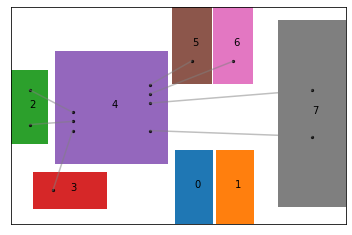

In [13]:
# init positions
boxes = []
for i, p in enumerate(range(len(compx))):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=False, pl=False, m=False))

fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
               max_seconds=3800, num_cores=numCores-1, name=design)
p, c = fp.layout()
print(fp.h.value)
fp.show()

In [14]:
xss = []
yss = []
for box in fp.boxes:
    xss.append(box.x.value)
    yss.append(box.y.value)
xss = np.array(xss)
yss = np.array(yss)
len(xss)

8

In [15]:
n = len(fp.boxes)
unweighted_adj = np.zeros((n,n))
for k in range(len(fp.nets)):
    net = fp.nets[k]
    for pi1, mix1 in enumerate(net.moduleidxs):
        for pi2, mix2 in enumerate(net.moduleidxs):
            unweighted_adj[mix1,mix2] = 1

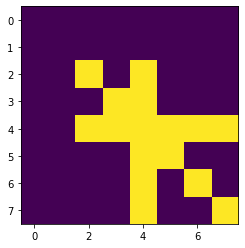

In [16]:
plt.imshow(unweighted_adj)

In [17]:
nx = np.array([b.x.value for b in fp.boxes])
ny = np.array([b.y.value for b in fp.boxes])

In [18]:
w = (unweighted_adj == 1)
positions = np.vstack([nx,ny]).T
numedges = jnp.where(w == 1)[0].shape[0]
edgetensor = np.zeros((numedges,)+positions.shape)
edgelist = jnp.where(w == 1)
for i in range(numedges):
    e1 = edgelist[0][i].item()
    e2 = edgelist[1][i].item()
    edgetensor[i,e1,0] = 1
    edgetensor[i,e2,1] = 1
edgetensor = jnp.array(edgetensor)

In [19]:
seed = 0
# initialise an array of 2D positions
rng = random.PRNGKey(seed)
eps = 1e-8
init_positions = random.normal(rng, (n,2))

"""
K=w
pi = jnp.zeros(K.shape)
x = jnp.zeros(K.shape)
U = jnp.ones((numedges,2))
r = jnp.ones(numedges)

params = (U, r)

opt_init, opt_update, get_params = optimizers.adam(1e-2, b1=0.9, b2=0.999, eps=1e-08)
opt_state = opt_init(params)
"""

'\nK=w\npi = jnp.zeros(K.shape)\nx = jnp.zeros(K.shape)\nU = jnp.ones((numedges,2))\nr = jnp.ones(numedges)\n\nparams = (U, r)\n\nopt_init, opt_update, get_params = optimizers.adam(1e-2, b1=0.9, b2=0.999, eps=1e-08)\nopt_state = opt_init(params)\n'

In [20]:
"""
Objectives
"""

def pairwise_dist(X):
    euc = lambda x: vmap(lambda y: jnp.linalg.norm(jnp.maximum(jnp.abs(x-y), eps))**2)(X)
    return vmap(euc)(X)

def _ec(X, U_i, r_i, A_i, B_i):
    return jnp.linalg.norm(jnp.clip(-A_i.T@X@U_i + (r_i + 1)*jnp.ones(U_i.shape[-1]), eps))**2 + \
           jnp.linalg.norm(jnp.clip(B_i.T@X@U_i - (r_i - 1)*jnp.ones(U_i.shape[-1]), eps))**2
    
def ec_objective(params, A, B):
    X, U, r = params
    return jnp.sum(vmap(partial(_ec,X))(U, r, A, B))

@jit
def ec_step(i, opt_state, edgetensor, fixed_idx=None):
    params = get_params(opt_state)
    g = grad(ec_objective)(params, edgetensor, edgetensor)
    # jax.ops.index_update was deprecated in v0.2.22, now use jax.numpy.ndarray.at
    # print("g shape: ", len(g))
    # print("g[0] shape: ", g[0].shape)
    # print("g[0][fixed_idx] val: ", g[0][jnp.array(fixed_idx)])
    g_0 = g[0].at[jnp.array(fixed_idx)].set(0)
    # g_0 = g[0].at[jnp.array(fixed_idx)].at[1].set(0)
    # g_0 = jax.ops.index_update(g[0], fixed_idx, 0)
    g = (g_0,g[1],g[2])
    return opt_update(i, g, opt_state)

In [21]:
def stress(params, W, D):
    X,_,_ = params
    pd = pairwise_dist(X)
    stress = jnp.multiply(W, jnp.square(pd - D))
    return jnp.sum(jnp.triu(stress)) + l*jnp.linalg.norm(X)**2

@jit
def step(i, opt_state, W, D, idx, fixed_idx=None):
    p,U,r = get_params(opt_state)
    g = grad(stress)((p[idx],U,r), W[jnp.ix_(idx,idx)], D[jnp.ix_(idx,idx)])
    # POTENTIAL BUG: jax.ops.index_add not supported
    # indices_are_sorted: whether `idx` is known to be sorted
    # unique_indices: whether `idx` is known to be free of duplicates
    # g_0 = jax.ops.index_add(jnp.zeros_like(p), idx, g[0], 
    #                       indices_are_sorted=False, unique_indices=True)
    g_0 = jnp.zeros_like(p).at[idx].add(g[0])
    # g_0 = jax.ops.index_update(g_0, fixed_idx, 0)
    g_0 = g_0.at[jnp.array(fixed_idx)].set(0)
    g = (g_0, g[1], g[2])
    return opt_update(i, g, opt_state)

In [22]:
d = csgraph.shortest_path(adj, directed=False, unweighted=False)
d = np.nan_to_num(d,nan=0.0, posinf=np.where(np.isinf(d),-np.Inf,d).max()+1)
# weights
eps = 1e-8
w = jnp.square(jnp.reciprocal(d + np.eye(*d.shape)))
w = w - jnp.diag(jnp.diag(w))
l = 0
dd = np.ones_like(w)
for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        dd[i,j]*=10*(max(comph[i],compw[i]) + max(comph[j],compw[j]))

d = d * dd

numedges = jnp.where(w == 1)[0].shape[0]
edgetensor = np.zeros((numedges,)+positions.shape)
edgelist = jnp.where(w == 1)
for i in range(numedges):
    e1 = edgelist[0][i].item()
    e2 = edgelist[1][i].item()
    edgetensor[i,e1,0] = 1
    edgetensor[i,e2,1] = 1
edgetensor = jnp.array(edgetensor)

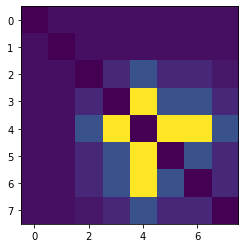

In [23]:
plt.imshow(w)

In [24]:
def rescale(X_transformed, minx, maxx, miny, maxy):
    X_transformed_x_rescaled = minx + ((X_transformed[:,0] - X_transformed[:,0].min())*(maxx - minx))/(X_transformed[:,0].max() - X_transformed[:,0].min())
    X_transformed_y_rescaled = miny + ((X_transformed[:,1] - X_transformed[:,1].min())*(maxy - miny))/(X_transformed[:,1].max() - X_transformed[:,1].min())
    #X_transformed_x_rescaled = np.minimum(np.maximum(minx, X_transformed[:,0]+minx+(maxx-minx)/2), maxx)
    #X_transformed_y_rescaled = np.minimum(np.maximum(miny, X_transformed[:,1]+miny+(maxy-miny)/2),maxy)
    X_transformed_rescaled = np.stack([X_transformed_x_rescaled,X_transformed_y_rescaled],axis=-1)
    return X_transformed_rescaled

In [25]:
def ulapeig(A, eps=1e-2):
    """
    Compute unnormalized Laplacian eigenmap embedding of a graph.
    L = D - A = Z Λ Zᵀ
    Returns the vectors Z.
    Parameters
    ----------
    A: (n_nodes x n_nodes) adjacency matrix
    Returns
    -------
    E: (n_nodes x n_nodes) Laplacian embeddings
    """
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    W, E = np.linalg.eigh(L)
    E = E @ np.diag(np.sign(W))
    return np.real(E)

In [26]:
def compute_structure_preserving_embedding(A, C = 100.0, verbose = False):
    """
    Compute the structure-preserving embedding of a graph using CVXPY.
    This does not actually scale beyond 10 x 10 or so.
    
    Parameters
    ----------
    A: (n_nodes x n_nodes) adjacency matrix
    Returns
    -------
    E: (n_nodes x n_nodes) LLE embeddings
    """
    n_nodes, _ = A.shape

    K = cp.Variable((n_nodes, n_nodes), PSD = True)
    xi = cp.Variable(1)

    D = cp.bmat([[K[i, i] + K[j, j] - 2 * K[i, j] \
                  for j in range(n_nodes)] \
                  for i in range(n_nodes)])
    M = cp.max(D, axis = 1)
    
    objective = cp.Maximize(cp.trace(K @ A) - C * xi)
    constraints = [cp.trace(K) <= 1, xi >= 0, cp.sum(K) == 0]
    for i, j in itertools.combinations(range(n_nodes), 2):
        constraints += [D[i, j] >= (1 - A[i, j]) * M[i] - xi]

    problem = cp.Problem(objective, constraints)
    result = problem.solve(verbose = verbose, solver = "SCS")
    
    L, Z = np.linalg.eigh(K.value)
    return Z

1


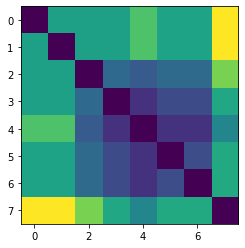

In [27]:
seed = 0
# initialise an array of 2D positions
rng = random.PRNGKey(seed)

K=w
pi = jnp.zeros(K.shape)
x = jnp.zeros(K.shape)
U = jnp.ones((numedges,2))
r = jnp.ones(numedges)
# show the shortest paths in a heat map.
# If any squares are white, then infinite paths exist and the algorithm will fail.
plt.imshow(d)
n = d.shape[0]
fixed_idx = [i for i,m in enumerate(movable) if m==False]

print(len(fixed_idx))

embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
X_transformed = embedding.fit_transform(w)
#X_transformed = np.asarray(random.normal(rng, (n,2)))


X_transformed_rescaled = rescale(X_transformed, minx, maxx, miny, maxy)
init_positions = np.array([ip if movable[i]==True else [compx[i],compy[i]] 
                           for i,ip in enumerate(X_transformed_rescaled) ])
params = (init_positions, U, r)
opt_init, opt_update, get_params = optimizers.adam(5e-2, b1=0.9, b2=0.999, eps=1e-08)
opt_state = opt_init(params)

In [28]:
len(w)

8

In [29]:
"""
degree = np.zeros(len(w)) # initialize list to hold values of degree

# calculate the sums along rows and sum along columns
colsum = w.sum(axis=0)
rowsum = w.sum(axis=1)

# loop through matrix and add up all degree connections
for j in range(0, len(w)):
    degree[j] = colsum[j] + rowsum[j]

# get the diagonal entries to correct the for loop oversumming
A = w.diagonal()
d = A.flatten()
diagMat = list(d)

# print the degree of connectivity matrix 
np.diag(degree - diagMat)
np.dot(np.matmul(X_transformed[:,0],np.diag(degree - diagMat)), np.ones_like(X_transformed[:,0]))
"""

'\ndegree = np.zeros(len(w)) # initialize list to hold values of degree\n\n# calculate the sums along rows and sum along columns\ncolsum = w.sum(axis=0)\nrowsum = w.sum(axis=1)\n\n# loop through matrix and add up all degree connections\nfor j in range(0, len(w)):\n    degree[j] = colsum[j] + rowsum[j]\n\n# get the diagonal entries to correct the for loop oversumming\nA = w.diagonal()\nd = A.flatten()\ndiagMat = list(d)\n\n# print the degree of connectivity matrix \nnp.diag(degree - diagMat)\nnp.dot(np.matmul(X_transformed[:,0],np.diag(degree - diagMat)), np.ones_like(X_transformed[:,0]))\n'

Compiled constraints
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 20 08:41:45 PM: Your problem has 108 variables, 312 constraints, and 0 parameters.
(CVXPY) Jul 20 08:41:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 08:41:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 08:41:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 08:41:45 PM: Compiling problem (target solver=CBC).
(CVXPY) Jul 20 08:41:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -

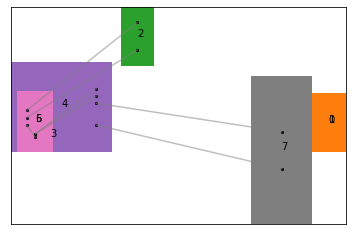

In [30]:
# init positions
boxes = []
for i, p in enumerate(init_positions):
    boxes.append(Box(compw[i], comph[i], p[0], p[1], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=False, pl=False, m=False))

fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
               max_seconds=1800, num_cores=numCores-1, name=design)
p, c = fp.layout()
fp.show()

Compiled constraints
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 20 08:41:45 PM: Your problem has 108 variables, 312 constraints, and 0 parameters.
(CVXPY) Jul 20 08:41:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 08:41:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 08:41:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 08:41:45 PM: Compiling problem (target solver=CBC).
(CVXPY) Jul 20 08:41:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -

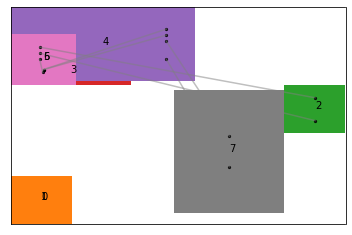

  0%|          | 0/1000 [00:00<?, ?it/s]

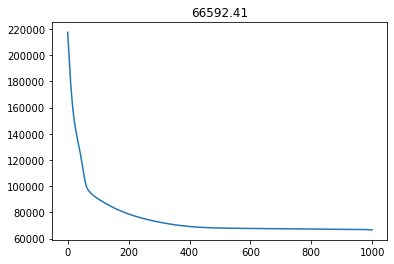

In [31]:
pl_hist = []
for _ in range(4):
    X_transformed = X_transformed[:,[1,0]]
    X_transformed[:,1]*=-1

    X_transformed_rescaled = rescale(X_transformed, minx, maxx, miny, maxy)
    init_positions = np.array([ip if movable[i]==True else [compx[i],compy[i]] 
                               for i,ip in enumerate(X_transformed_rescaled) ])
    params = (init_positions, U, r)
    opt_init, opt_update, get_params = optimizers.adam(1e-1, b1=0.9, b2=0.999, eps=1e-08)
    opt_state = opt_init(params)    
    
    # init positions
    boxes = []
    for i, p in enumerate(init_positions):
        boxes.append(Box(compw[i], comph[i], p[0], p[1], 
                         initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                         r=False, pl=False, m=False))

    fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
                   margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
                   max_seconds=1800, num_cores=numCores-1, name=design)
    p, c = fp.layout()
    fp.show()
    
    eta=1e-2
    l=1e-1
    itercount = itertools.count()

    stress_hist = []
    ec_hist = []
    cvx_clst_hist = []
    param_hist = []

    for i in tqdm(range(1000)):
        idx = np.arange(n)
        opt_state = ec_step(i, opt_state, edgetensor, fixed_idx=fixed_idx)
        opt_state = step(i, opt_state, w, d, idx, fixed_idx=fixed_idx)

        params = get_params(opt_state)
        param_hist.append(params)
        stress_hist.append(stress(params, w, d))
        ec_hist.append(ec_objective(params, edgetensor, edgetensor))

    end = datetime.datetime.now()
    plt.plot(stress_hist)
    plt.title(stress(params, w, d))
    pl_hist.append(param_hist)
    break

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, '62332.5')

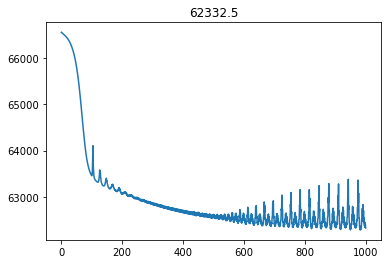

In [32]:
eta=1e-2
l=1e-1
itercount = itertools.count()

stress_hist = []
ec_hist = []
cvx_clst_hist = []
param_hist = []

for i in tqdm(range(1000)):
    idx = np.arange(n)
    for _ in range(40):
        opt_state = ec_step(i, opt_state, edgetensor, fixed_idx=fixed_idx)
    opt_state = step(i, opt_state, w, d, idx, fixed_idx=fixed_idx)
    
    params = get_params(opt_state)
    param_hist.append(params)
    stress_hist.append(stress(params, w, d))
    ec_hist.append(ec_objective(params, edgetensor, edgetensor))
        
end = datetime.datetime.now()
plt.plot(stress_hist)
plt.title(stress(params, w, d))

In [33]:
param_hist = pl_hist[0]

In [34]:
positions,_,_ = param_hist[0]

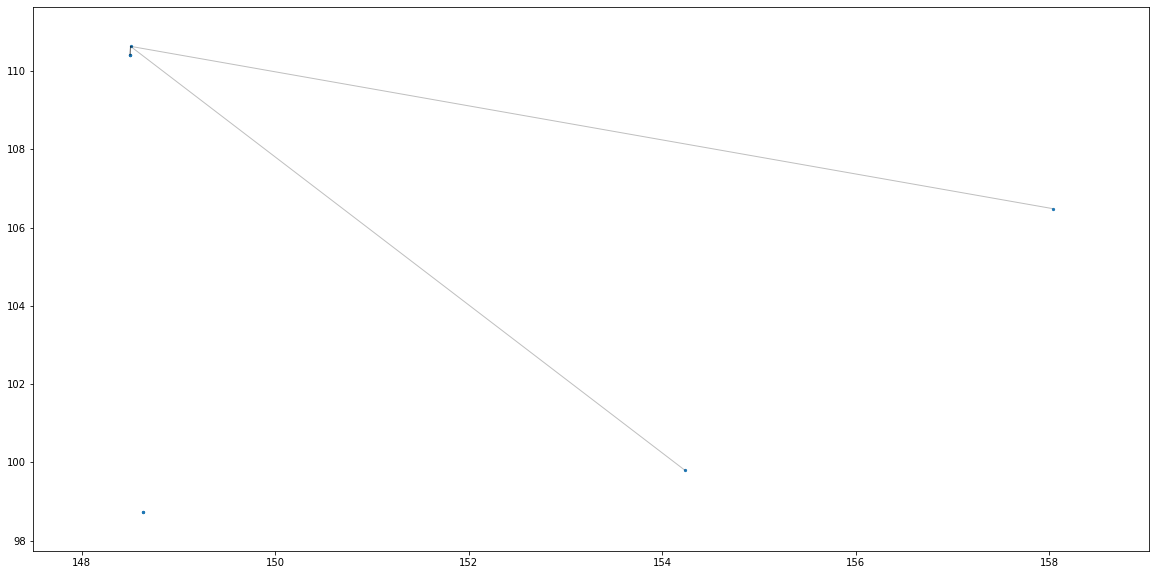

In [35]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_xlim(min(positions[:,0])-1, max(positions[:,0])+1)
ax.set_ylim(min(positions[:,1])-1, max(positions[:,1])+1)

lines = []
for i,j in zip(*adj.nonzero()):
    if i > j:
        lines.append([positions[i], positions[j]])

lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.25)
ax.add_collection(lc)
ax.scatter(positions[:,0], positions[:,1], s=5)
#plt.savefig(graph_name + '.svg', format='svg', dpi=1000)

In [36]:
"""
import time
from IPython.display import clear_output

idx = np.linspace(0, len(param_hist)-1, num=25,dtype=int)
for _ in range(1):
    for j in idx:
        positions,_,_ = param_hist[j]
        
        positions_x_rescaled = minx + ((positions[:,0] - positions[:,0].min())*(maxx - minx))/(positions[:,0].max() - positions[:,0].min())
        positions_y_rescaled = miny + ((positions[:,1] - positions[:,1].min())*(maxy - miny))/(positions[:,1].max() - positions[:,1].min())
        positions_rescaled = np.stack([positions_x_rescaled,positions_y_rescaled],axis=-1)
        fixed_idx = [i for i,m in enumerate(movable) if m==False]
        positions = np.array([ip if movable[i]==True else [compx[i],compy[i]] 
                                   for i,ip in enumerate(positions_rescaled) ])
        
        boxes = []
        for i in range(len(compw)):
            boxes.append(Box(compw[i], comph[i], positions[i,0].item(), positions[i,1].item(), 
                             initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                             r=False, pl=False, m=False))

        fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
                       margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
                       max_seconds=3600, num_cores=numCores-1, name=design)
        p, c = fp.layout()
        clear_output(wait=True)
        fp.show(True,j)
        time.sleep(0.1)
    """

'\nimport time\nfrom IPython.display import clear_output\n\nidx = np.linspace(0, len(param_hist)-1, num=25,dtype=int)\nfor _ in range(1):\n    for j in idx:\n        positions,_,_ = param_hist[j]\n        \n        positions_x_rescaled = minx + ((positions[:,0] - positions[:,0].min())*(maxx - minx))/(positions[:,0].max() - positions[:,0].min())\n        positions_y_rescaled = miny + ((positions[:,1] - positions[:,1].min())*(maxy - miny))/(positions[:,1].max() - positions[:,1].min())\n        positions_rescaled = np.stack([positions_x_rescaled,positions_y_rescaled],axis=-1)\n        fixed_idx = [i for i,m in enumerate(movable) if m==False]\n        positions = np.array([ip if movable[i]==True else [compx[i],compy[i]] \n                                   for i,ip in enumerate(positions_rescaled) ])\n        \n        boxes = []\n        for i in range(len(compw)):\n            boxes.append(Box(compw[i], comph[i], positions[i,0].item(), positions[i,1].item(), \n                           

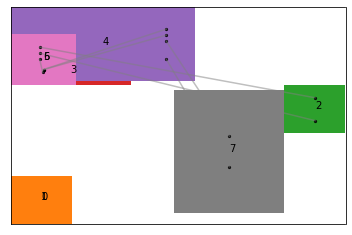

In [37]:
fp.show()

In [38]:
positions,_,_ = param_hist[-1]
positions_x_rescaled = minx + ((positions[:,0] - positions[:,0].min())*(maxx - minx))/(positions[:,0].max() - positions[:,0].min())
positions_y_rescaled = miny + ((positions[:,1] - positions[:,1].min())*(maxy - miny))/(positions[:,1].max() - positions[:,1].min())
positions_rescaled = np.stack([positions_x_rescaled,positions_y_rescaled],axis=-1)
fixed_idx = [i for i,m in enumerate(movable) if m==False]
positions = np.array([ip if movable[i]==True else [compx[i],compy[i]] 
                           for i,ip in enumerate(positions_rescaled) ])

boxes = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], positions[i,0].item(), positions[i,1].item(), 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=movable[i], pl=movable[i], m=False))
                     #r=False, pl=False, m=False))

#fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
#               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
#               max_seconds=1800, num_cores=numCores-1, name=design)
#p, c = fp.layout()
#clear_output(wait=True)
#fp.show()

In [39]:
# order constraints
vo = []
ho = []

norelpairs = []


for i1, x1 in enumerate(param_hist[-1][0]):
    for i2, x2 in enumerate(param_hist[-1][0]):
        if i2 <= i1 or ((not movable[i1]) or (not movable[i2])):
            continue
        # if distance greater than threshold
        if max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > 25:
            if abs(x1[0] - x2[0]) < abs(x1[1] - x2[1]):
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2,i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2,i1]) 
        else:
            norelpairs.append([i1,i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]
print('num constrants:',len(horiz_order),len(vert_order))
fp = FloorPlan(boxes, nets,adj,obj=True,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
               max_seconds=3800, num_cores=numCores-1, name=design)

num constrants: 0 0


In [40]:
%%time
p, c = fp.layout()

Compiled constraints
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 20 08:42:05 PM: Your problem has 261 variables, 648 constraints, and 0 parameters.
(CVXPY) Jul 20 08:42:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 08:42:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 08:42:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 08:42:05 PM: Compiling problem (target solver=CBC).
(CVXPY) Jul 20 08:42:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -

In [41]:
# 92.70
# 89.75
# 67.449
# 1862.01040
# 2744.626
fp.h.value

29.976999921813714

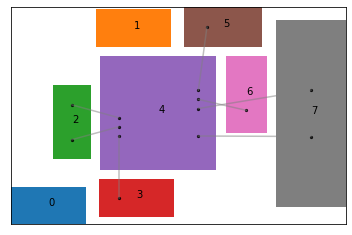

In [42]:
violations = fp.verify_constraints(c) # coimp 4 mirror x axis
#assert np.all(violations <= 1e-5)
fp.show()

In [43]:
for i in range(db.getInstancesCount()):
    box = fp.boxes[i]
    
    xpos = box.x.value.item()
    ypos = box.y.value.item()
    print(i, xpos, ypos, box.w, box.h)

0 140.03359999999998 98.8434 2.06 4.04
1 144.5736 108.5104 2.06 4.04
2 142.27300000000002 102.39040006393269 2.06 4.04
3 144.73399998509396 99.25040000000001 2.06 4.04
4 144.833 101.8104 6.2 6.2
5 149.27399998509395 108.51040000000002 2.2 4.2
6 151.53300000000004 103.81040000000002 2.2 4.2
7 154.233 99.802 3.7 10.2


In [44]:
for i in range(db.getInstancesCount()):
    inst = db.getInstance(i)
    compid = inst.getComponentId()
    
    box = fp.boxes[i]
    
    xpos = box.x.value.item() + 0.5 * ((1-fp.boxes[i].r.value)*fp.boxes[i].w.value + 
                                          (fp.boxes[i].r.value)*fp.boxes[i].h.value)
    ypos = box.y.value.item()+ 0.5 * ((1-fp.boxes[i].r.value)*fp.boxes[i].h.value + 
                                         (fp.boxes[i].r.value)*fp.boxes[i].w.value)
    inst.setX(xpos)
    inst.setY(ypos)

    rotated = box.r.value
    mirroredX = box.mx.value.item()
    mirroredY = box.my.value.item()
    
    init_angle = inst.getAngle()
    """
    if (init_angle == 0):
        initrot.append(False)
        initm.append(False)
    elif (init_angle == 90):
        initrot.append(True)
        initm.append(False)
    elif (init_angle == 180):
        initrot.append(False)
        initm.append(True)
    elif (init_angle == 270):
        initrot.append(True)
        initm.append(True)
    """  
    print(i, xpos, ypos, box.w, box.h,init_angle, rotated)
    #ORIENTATION 0 90 -90
    if (init_angle==0) and (rotated == 0.0):
        inst.setAngle(90)
    elif (init_angle==0) and (rotated == 1.0):
        inst.setAngle(0)
    elif (init_angle==90) and (rotated == 0.0):
        inst.setAngle(90)
    elif (init_angle==90) and (rotated == 1.0):
        inst.setAngle(180)
    elif (init_angle==180) and (rotated == 0.0):
        inst.setAngle(270)
    elif (init_angle==180) and (rotated == 1.0):
        inst.setAngle(180)
    elif (init_angle==270) and (rotated == 0.0):
        inst.setAngle(270)
    elif (init_angle==270) and (rotated == 1.0):
        inst.setAngle(0)
    print(i, xpos, ypos, box.w, box.h,inst.getAngle(), rotated)    
    
    #if rotated==1.0:
    #    inst.setAngle(0)
    #else:
    #    inst.setAngle(90)

0 142.0536 99.8734 2.06 4.04 270.0 1.0
0 142.0536 99.8734 2.06 4.04 0.0 1.0
1 146.5936 109.5404 2.06 4.04 270.0 1.0
1 146.5936 109.5404 2.06 4.04 0.0 1.0
2 143.30300000000003 104.41040006393268 2.06 4.04 90.0 0.0
2 143.30300000000003 104.41040006393268 2.06 4.04 90.0 0.0
3 146.75399998509397 100.28040000000001 2.06 4.04 180.0 1.0
3 146.75399998509397 100.28040000000001 2.06 4.04 180.0 1.0
4 147.933 104.9104 6.2 6.2 270.0 0.0
4 147.933 104.9104 6.2 6.2 270.0 0.0
5 151.37399998509395 109.61040000000001 2.2 4.2 270.0 1.0
5 151.37399998509395 109.61040000000001 2.2 4.2 0.0 1.0
6 152.63300000000004 105.91040000000001 2.2 4.2 270.0 0.0
6 152.63300000000004 105.91040000000001 2.2 4.2 270.0 0.0
7 156.083 104.902 3.7 10.2 90.0 0.0
7 156.083 104.902 3.7 10.2 90.0 0.0


In [45]:
# db.printKiCad()

In [46]:
!ls -lrt

total 532
-rw-rw-r-- 1 yuw yuw   1070 Jul 17 19:33 LICENSE
drwxrwxr-x 2 yuw yuw   4096 Jul 17 19:33 KicadParser
-rw-rw-r-- 1 yuw yuw    255 Jul 17 19:33 install_conda.sh
drwxrwxr-x 4 yuw yuw   4096 Jul 17 19:33 input_pin_aware
-rw-rw-r-- 1 yuw yuw  12167 Jul 17 19:33 floorplan_smt.py
-rw-rw-r-- 1 yuw yuw    327 Jul 17 19:33 CMakeLists.txt
-rw-rw-r-- 1 yuw yuw   1534 Jul 17 19:33 cmake_install.cmake
drwxrwxr-x 4 yuw yuw   4096 Jul 17 19:33 CMakeFiles
-rwxrwxr-x 1 yuw yuw     33 Jul 17 19:33 clean
drwxrwxr-x 2 yuw yuw   4096 Jul 17 19:33 src
-rw-rw-r-- 1 yuw yuw   4408 Jul 17 19:33 requirements.txt
-rw-rw-r-- 1 yuw yuw  28615 Jul 17 19:33 placedb.py
drwxrwxr-x 3 yuw yuw   4096 Jul 17 23:24 ucsdpcb
drwxrwxr-x 2 yuw yuw   4096 Jul 19 05:41 _PCBBenchmarks
-rw-rw-r-- 1 yuw yuw  25456 Jul 20 12:12 original_test.png
-rw-rw-r-- 1 yuw yuw  20713 Jul 20 12:12 floorplan.py
drwxrwxr-x 2 yuw yuw   4096 Jul 20 12:25 __pycache__
drwxrwxr-x 4 yuw yuw   4096 Jul 20 12:26 PCBBenchmarks
-rw-rw-r-- 1 yuw y

In [47]:
!pwd

/home/yuw/Desktop/Github/PCBPlacer/PCBPlacer


In [48]:
!ls PCBBenchmarks/bm7/bm7.routed.kicad_pcb

ls: cannot access 'PCBBenchmarks/bm7/bm7.routed.kicad_pcb': No such file or directory


In [49]:
opt_init, opt_update, get_params = optimizers.adam(5e-2, b1=0.9, b2=0.999, eps=1e-08)
opt_state = opt_init(param_hist[-1])

In [50]:
# edge cut cost
h = []
for _ in range(500):
    opt_state = ec_step(i, opt_state, edgetensor)
    params = get_params(opt_state)

    ob = ec_objective(params, edgetensor, edgetensor)
    h.append(np.log(ob))
plt.plot(h)

TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 0, indexer value Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>

In [ ]:
h[-1]